# CEE501 How Cities Work: Student Hometown Visualization
## Setup
First, we need to impot some libraries. The `pandas` and `geopandas` libraries will make it easier to manipulate the data and `matplotlib` will visualize it. We also import `defaultdict` from Python's built-in `collections` library to make dictionary-based code a bit cleaner.

In [1]:
from collections import defaultdict
from math import log
import locale

import requests
import pandas as pd
import matplotlib.cm  as cm
import matplotlib.pyplot as plt
import geopandas as gpd
import geopy as gpy
import numpy as np


In [2]:
# Setup locale info
_ = locale.setlocale(locale.LC_ALL, 'en_US.UTF-8')

# Set some useful constants
DECILES = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

# Set up colors for later
BLUE = (0x00/0xff, 0x27/0xff, 0x4c/0xff, 1.)
MAIZE = (0xff/0xff, 0xcb/0xff, 0x05/0xff, 1.)

cm.register_cmap(name='umich',
                 data={'red':   [(0.,BLUE[0], BLUE[0]),
                                 (1.,MAIZE[0], MAIZE[0])],
                       
                       'green': [(0.,BLUE[1], BLUE[1]),
                                 (1.,MAIZE[1], MAIZE[1])],
                       
                       'blue':  [(0.,BLUE[2], BLUE[2]),
                                 (1.,MAIZE[2], MAIZE[2])],
                       
                       'alpha': [(0.,1,1),
                                 (1.,1,1)],})

For posterity's sake I've left the cell below in, which shows how I did the geocoding for each city. It is now a Markdown cell with Python markup, and the pre-processed data should be loaded as in the cell below it.

```python
from time import sleep
with open("How_Cities_Work_Data.csv", "r") as data_file:
    student_df = pd.read_csv(data_file)

city_geocodes_df = None
cities_gotten = set()
for idx, data in student_df.iterrows():
    city_str = f"{data['City']} {data['State']+' ' if str(data['State']) != 'nan' else ''}{data['Country']}"
    if city_str in cities_gotten:
        continue
    print(city_str)
    
    try:
        city_geocode = gpd.tools.geocode(city_str, provider='openmapquest', api_key="{KEY}")
    except:
        sleep(1)
        city_geocode = gpd.tools.geocode(city_str, provider='openmapquest', api_key="{KEY}")
    city_geocode['City'] = data['City']
    city_geocode['State'] = data['State']
    city_geocode['Country'] = data['Country']
    sleep(1)
    cities_gotten.add(city_str)
    
    if city_geocodes_df is None:
        city_geocodes_df = city_geocode
    else:
        city_geocodes_df = city_geocodes_df.append(city_geocode, ignore_index=True)
student_df = city_geocodes_df.merge(student_df, how='right')
student_df.to_file('cities.shp')
```

In [3]:
# Load student city data with accompanying geocodes
student_df = gpd.read_file('cities.shp')

# Convert Pop (est.) to floats
student_df['Pop (est.)'] = student_df['Pop (est.)'].apply(lambda p: float(p.replace(',', '')) if p is not None else float("NaN"))

# Convert Pop (true) to floats
student_df['Pop (true)'] = student_df['Pop (true)'].apply(lambda p: float(p.replace(',', '')) if p is not None else float("NaN"))

student_df

,address,City,State,Country,Pop (est.),Pop (true),Note,geometry
0,"Novi, Oakland County, Michigan, United States ...",Novi,MI,USA,59000.0,59715.0,None,POINT (-83.4754913 42.48059)
1,"Novi, Oakland County, Michigan, United States ...",Novi,MI,USA,45000.0,59715.0,None,POINT (-83.4754913 42.48059)
2,"Novi, Oakland County, Michigan, United States ...",Novi,MI,USA,55000.0,59715.0,12 Oaks Mall,POINT (-83.4754913 42.48059)
3,"Grajewo, powiat grajewski, podlaskie, RP",Grajewo,None,Poland,23000.0,22434.0,it is walkable,POINT (22.4553891 53.6475674)
4,"Parkland, Broward County, Florida, 33067, Unit...",Parkland,FL,USA,30000.0,32202.0,None,POINT (-80.23727 26.3100794)
...,...,...,...,...,...,...,...,...
127,"Dakota County, Minnesota, United States of Ame...",Dakota,MN,USA,400.0,308.0,My elementary school is now a dog hotel,POINT (-93.044911 44.666655)
128,"Clinton County, Michigan, United States of Ame...",Clinton,MI,USA,2000.0,95648.0,None,POINT (-84.6125345 42.9435238)
129,"West Middlesex, Mercer County, Pennsylvania, 1...",West Middlesex,PA,USA,800.0,821.0,1 stoplight in town,POINT (-80.453402 41.174224)
130,"Oxford, Iowa, United States of America",Oxford,IA,USA,800.0,808.0,None,POINT (-91.79045259999999 41.7233444)


## Basic Statistics

Let's do some basic statistics on our responses, just to get a feel for what we're looking at, and what the class was like. First, we need to get the number of respondents who filled out each field of information. We recorded data about respondents' city name, state (if they lived in the U.S.) and country, their estimate of how many people live in their city, the true number of residents according to the latest official census, and any notes they chose to include. Each data point is a different column in the `student_df` `DataFrame`. We can use all this data in a number of different ways. First, lets just get the number of responses for each question.

In [4]:
# Get the total number of responses
total_responses = len(student_df)

# Get the number of non-empty entries for each column 
address_ct, city_ct, state_ct, country_ct, pop_est_ct, pop_true_ct, note_ct, geometry_ct = student_df.count()

print(f"Cities: {city_ct}")
print(f"Population estimates: {pop_est_ct}")
print(f"Interesting notes: {note_ct}")

print(f"{total_responses} students responded to the survey!")

Cities: 132
Population estimates: 129
Interesting notes: 81
132 students responded to the survey!


So we have 132 responses, not bad! Shame on those 3 people who didn't even try to guess their city's population. We also have 81 notes on what's interesting in our cities, which is pretty cool! Let's see how many different places are represented in our class. We'll count how many unique cities, U.S. states, and countries were given as responses.

In [5]:
num_cities = student_df['City'].nunique()
num_states = student_df['State'].nunique(dropna=True)
num_countries = student_df['Country'].nunique()

print(f"Number of cities: {num_cities}")
print(f"Number of U.S. states: {num_states}")
print(f"Number of countries: {num_countries}")

Number of cities: 107
Number of U.S. states: 26
Number of countries: 16


Members of our class hail from 107 different cities in 16 countries, so we're very much an international group! Even within the U.S., we have members in 26 different states. Now, let's compute the some important distribution stats for the true populations of cities our classmates come from. We'll do the mean and median, the skew, the first and third quartiles, and then bin them into deciles.

In [6]:
# First, get the true pop series for easier coding
true_pop = student_df['Pop (true)']

true_pop_mean = true_pop.mean()
true_pop_median = true_pop.median()
true_pop_skew = true_pop.skew()
true_pop_lower_quartile = true_pop.quantile(0.25)
true_pop_upper_quartile = true_pop.quantile(0.75)
true_pop_deciles = true_pop.quantile([0.0,] + DECILES + [1.0,])


print(f"""True Population Statistics:
> Mean: {true_pop_mean:#.9n}
> Skew: {true_pop_skew:.3f}
> Median: {true_pop_median:#.7n}
> Lower Quartile: {true_pop_lower_quartile:#.7n}
> Upper Quartile: {true_pop_upper_quartile:#.8n}
> 1st Decile: {true_pop_deciles[0.1]:#.6n}
> 9th Decile: {true_pop_deciles[0.9]:#.9n}
"""
)

True Population Statistics:
> Mean: 1,705,772.08
> Skew: 3.676
> Median: 95,069.50
> Lower Quartile: 21,273.50
> Upper Quartile: 673,104.00
> 1st Decile: 4,015.00
> 9th Decile: 2,716,000.00



We can see that the population distribution is clearly and unsurprisingly skewed right: just a few very large cities pull the mean population way up. Using the median as our measure of "average", we can see that the average student in our class comes from a city of around 100,000 people. The spread is quite broad: a quarter of the class is from cities (or maybe towns) with less than 22,000 residents, and a quarter is from cities larger than 650,000. Since our data is so skewed, let's use a box-and-whiskers plot on a log-scale to visualize our population statistics:

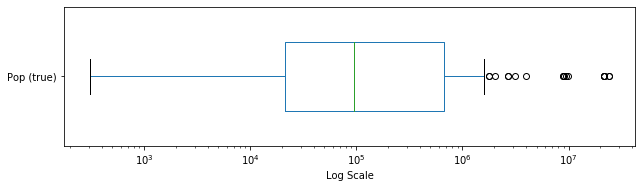

In [9]:
fix, ax = plt.subplots(figsize=(10.24, 2.56))
ax.set_xscale("log")
ax.set_xlabel("Log Scale")
true_pop_hist = true_pop.plot.box(ax=ax, vert=False, widths=0.5)

So we can definitely see that most people live in cities between about 20,000 and 500,000 people, while just a few of our students live in megalopolises with millions or even tens of millions of people. One the other end, a small group of students live in very small towns, with populations in the thousands or even hundreds. Let's take a look at these extremes.

In [10]:
# First, we need to get a list of unqiue cities and their populations
unique_cities = student_df.drop_duplicates(subset="City")[['City', 'State', 'Country', 'Pop (true)']]

largest_cities = unique_cities.nlargest(n=5, columns='Pop (true)')
smallest_cities = unique_cities.nsmallest(n=5, columns='Pop (true)')

print("Largest Cities:")
rank = 1
for row_id, row in largest_cities.iterrows():
    city_name = f"{row['City']}, {row['Country']}"
    padding = " "*(25 - len(city_name))
    print(f"{rank}. {city_name}{padding}{row['Pop (true)']:>11.18n}")
    rank += 1

print()

print("Smallest Cities:")
rank = 1
for row_id, row in smallest_cities.iterrows():
    city_name = f"{row['City']}, {row['State']} {row['Country']}"
    padding = " "*(25 - len(city_name))
    print(f"{rank}. {city_name}{padding}{row['Pop (true)']:>11.18n}")
    rank += 1

Largest Cities:
1. Shanghai, China           24,200,000
2. Beijing, China            21,700,000
3. Seoul, South Korea         9,970,000
4. Zhengzhou, China           9,570,000
5. Hangzhou, China            9,020,000

Smallest Cities:
1. Dakota, MN USA                   308
2. Caseville, MI USA                735
3. Oxford, IA USA                   808
4. West Middlesex, PA USA           821
5. Continental, OH USA            1,120


Possibly unsurprisingly, the five largest cities are all in east Asia, and four of the five are in China. The smallest cities are all in the U.S., and generally in mid-west states. 

## U.S. vs Non-U.S. Respondents

Now let's look at our respondents by nationality. We can easily figure out how many U.S. students responded by looking at the number of responses with state entries, since only U.S. cities were recorded with states. 

Total number of respondents: 132
Number of U.S. cities: 104
Number of non-U.S. cities: 28
Portion of respondents from the U.S.: 78.8%


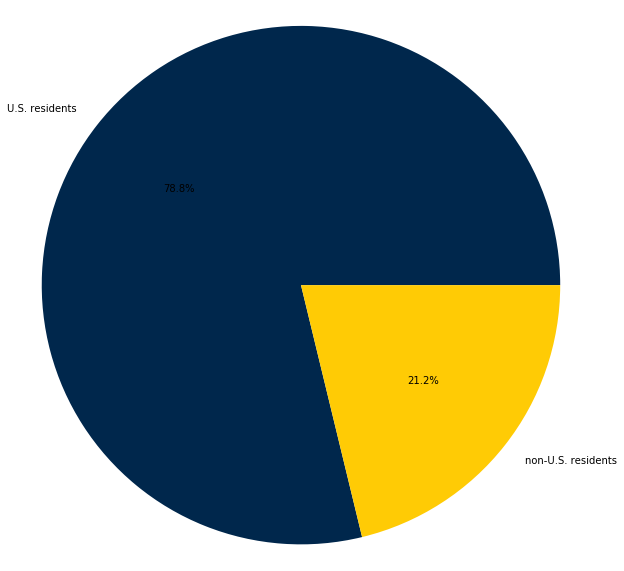

In [11]:
# Print the number of total respondents and the number of U.S. respondents
us_resident_ct = state_ct  # since only U.S. cities had states entered.
non_us_resident_ct = total_responses - us_resident_ct
print(f"Total number of respondents: {total_responses}")
print(f"Number of U.S. cities: {us_resident_ct}")
print(f"Number of non-U.S. cities: {non_us_resident_ct}")
print(f"Portion of respondents from the U.S.: {round(us_resident_ct/total_responses*100, 1)}%")

us_vs_non_us_fig, us_vs_non_us_ax = plt.subplots(figsize=(10.24, 10.24))
us_vs_non_us_pie = us_vs_non_us_ax.pie([us_resident_ct, non_us_resident_ct],
                                       labels=["U.S. residents", "non-U.S. residents"],
                                       autopct='%1.1f%%',
                                       colors=[BLUE, MAIZE])
us_vs_non_us_ax.axis('equal')
plt.show()

So our survey received 132 responses of which 104, approximately 80%, were from the U.S. First, let's dig into the U.S. numbers a bit more, looking at where our U.S.-based respondents live. Then we'll zoom back out, adding international students into the mix.

### U.S. Respondents

We'll start by looking at a state-level breakdown, seeing how many respondents we have from each U.S. state. First, we'll plot the number of residents from each state on a log scale, since Michigan dominates all other states. 

States in descending order of respondents:


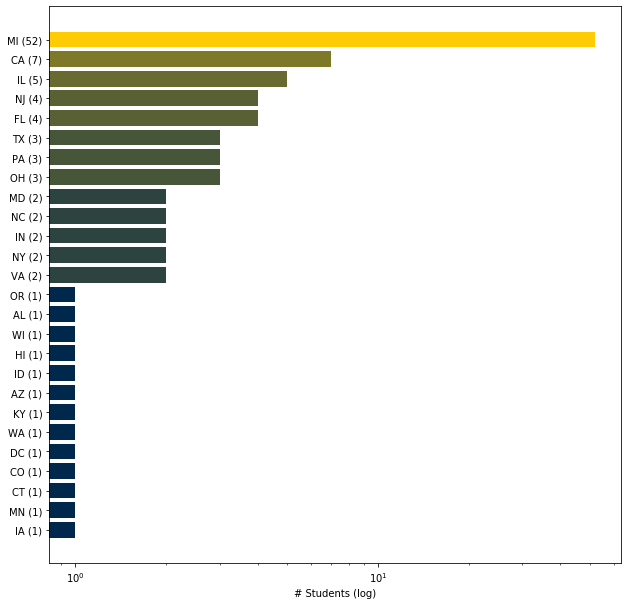

Total states represented: 26


In [13]:
# We count the respondents from each state
state_resident_nums = defaultdict(int)
for s in student_df['State']:
    if type(s) != str:
        continue
    state_resident_nums[s] += 1
state_residents_df = pd.DataFrame({'STUSPS': list(state_resident_nums.keys()),
                                   'respondents': list(state_resident_nums.values())})
states_represented = list(state_resident_nums.keys())

# Sort the resulting DataFrame in descending order
state_residents_df.sort_values('respondents', inplace=True, ascending=False)

# Plot the data in a horizontal bar graph
print("States in descending order of respondents:")

data_indices = range(len(states_represented), 0, -1)
data_values = list(state_residents_df['respondents'])
data_colors = [cm.get_cmap('umich')(log(v)/log(max(data_values))) for v in data_values]
data_y_labels = [f"{s_row[1]['STUSPS']} ({s_row[1]['respondents']})" for s_row in state_residents_df.iterrows()]

state_residents_bar_fig, state_residents_bar_ax = plt.subplots(figsize=(10.24, 10.24))
state_residents_bar = state_residents_bar_ax.barh(data_indices,
                                                  data_values,
                                                  color=data_colors,
                                                  tick_label=data_y_labels,
                                                  log=True)
state_residents_bar_ax.set_xlabel("# Students (log)")
plt.show()
print(f"Total states represented: {len(states_represented)}")

For a different view, we'll shade the states on a map of the U.S. from blue to maize, with more yellow indicating more residents. I've excluded Alaska and minor outlying territories to make the plot easier to view, since we have no respondents from any of these. Additionally, since the distribution of respondents follows the power law, I've applied a logarithmic scale to the number of respondents.

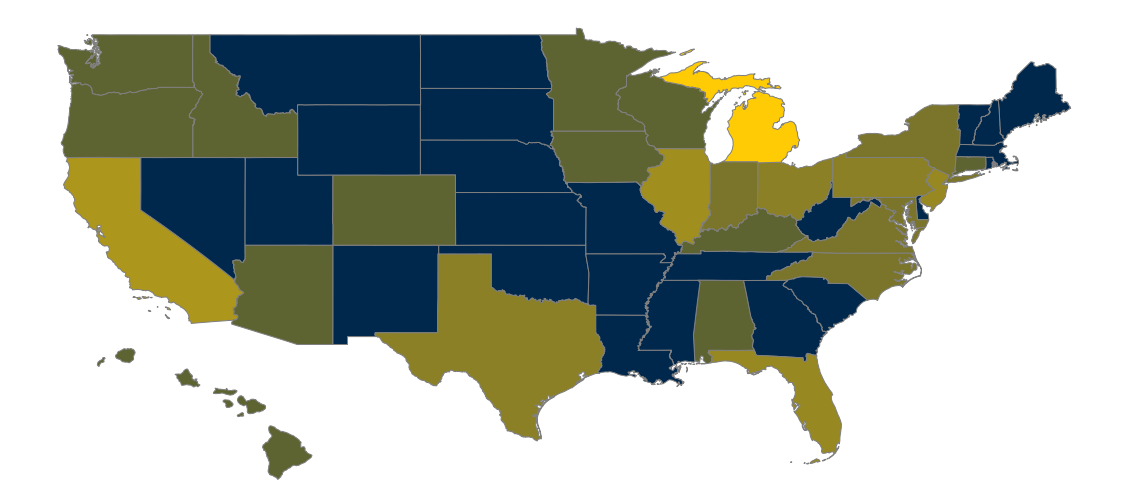

In [14]:
# First, load U.S. state shapefiles, which I downloaded from the U.S. Census Bureau 
# https://www.census.gov/geographies/mapping-files/time-series/geo/carto-boundary-file.html
us_data = gpd.read_file('us_state_shapefiles/cb_2018_us_state_5m.shp')
us_data.to_crs(epsg=4269)
us_data = us_data.loc[us_data['STUSPS'].isin(['AK', 'VI', 'MP', 'GU', 'AS', 'VI', 'PR']) == False]  # Exclude Alaska and minor territories


# Then we add the number of respondents to the US data
us_data = pd.merge(us_data, state_residents_df, how='left')
us_data['respondents'] = us_data['respondents'].apply(lambda v: 0 if str(v) == "nan" else int(v))
us_data['respondents_log'] = us_data['respondents'].apply(lambda v: 0 if v == 0 else log(v,10) + 1)

# Separated the US data into Hawaii and non-Hawaii for better maps
us_data_no_hi = us_data.loc[us_data['STUSPS'] != "HI"]
us_data_hi_only = us_data.loc[us_data['STUSPS'] == "HI"]

# Finally, plot the data
state_residents_fig = plt.figure(figsize=(9.99*2, 3.33*2))

state_residents_no_hi_ax = state_residents_fig.add_subplot(2,1,1)
us_data_no_hi.plot(ax=state_residents_no_hi_ax,
                   column='respondents_log',
                   cmap='umich',
                   edgecolor='grey')

state_residents_hi_ax = state_residents_fig.add_subplot(2,1,2)
us_data_hi_only.plot(ax=state_residents_hi_ax,
                     color=cm.get_cmap('umich')(us_data_hi_only['respondents_log']/(log(52, 10)+1)),
                     edgecolor='grey'
                    )
state_residents_no_hi_ax.set_position((0,0,0.8,1))
state_residents_hi_ax.set_position((0,0,0.3,0.3))

state_residents_no_hi_ax.set_axis_off()
state_residents_hi_ax.set_axis_off()
plt.show()

Finally, let's get even more granular: we'll plot all the U.S. cities our respondents listed. The more respondents come from a particular city, the bigger the dot we'll place will be.

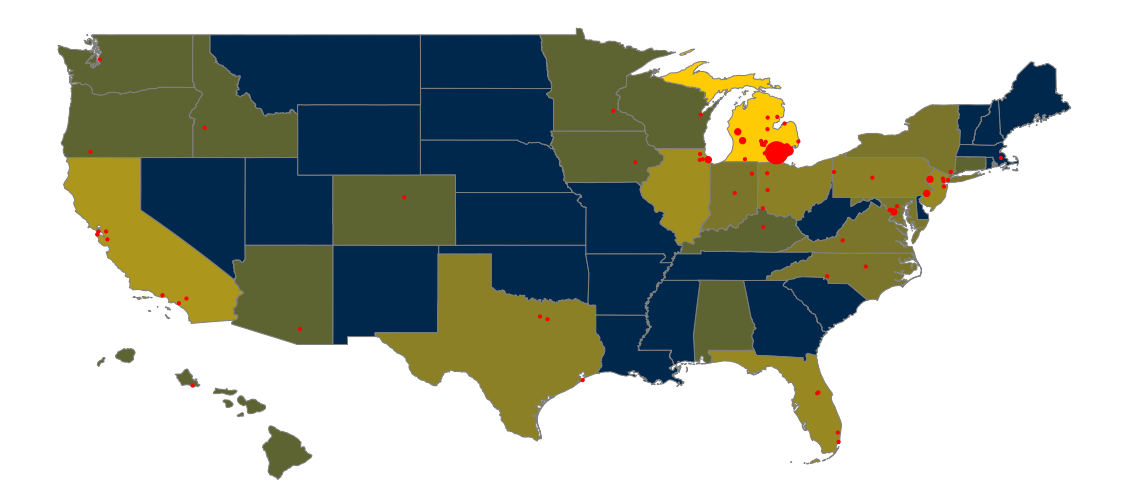

In [35]:
# Count how many respondents are from each city. We do this for all cities here so we don't need to do 
# this whole thing again later
city_resident_nums = defaultdict(int)
for c in student_df['City']:
    city_resident_nums[c] += 1
city_residents_df = pd.DataFrame({'City': list(city_resident_nums.keys()),
                                  'respondents': list(city_resident_nums.values())})

# Add geocode data to respondents DataFrame and get the cities represented
city_residents_df = student_df.merge(city_residents_df, how='left')
cities_represented = set(city_residents_df['address'])

# Collapse DataFrame so each city has only one entry
temp_city_residents_df = None
for addr in cities_represented:
    city_df = city_residents_df.loc[city_residents_df['address'] == addr].head(1)
    if temp_city_residents_df is None:
        temp_city_residents_df = city_df
    else:
        temp_city_residents_df = temp_city_residents_df.append(city_df)
city_residents_df = temp_city_residents_df

# Sort the cities by number of respondents and create a new column for dot size
city_residents_df.sort_values('respondents', inplace=True, ascending=False)
city_residents_df['dot_size'] = 10*city_residents_df['respondents']**2

# Now we select only U.S. cities
us_city_residents_df = city_residents_df.loc[city_residents_df['Country'] == "USA"]    

# Like last time, we want to split Hawaii and non-Hawaii data
us_city_residents_no_hi = us_city_residents_df.loc[us_city_residents_df['State'] != "HI"]
us_city_residents_hi = us_city_residents_df.loc[us_city_residents_df['State'] == "HI"]


# We start by recreating the previous map
cities_us_fig = plt.figure(figsize=(9.99*2, 3.33*2))

cities_us_no_hi_ax = cities_us_fig.add_subplot(2,1,1)
us_data_no_hi.plot(ax=cities_us_no_hi_ax,
                   column='respondents_log',
                   cmap='umich',
                   edgecolor='grey')

cities_us_hi_ax = cities_us_fig.add_subplot(2,1,2)
us_data_hi_only.plot(ax=cities_us_hi_ax,
                     color=cm.get_cmap('umich')(us_data_hi_only['respondents_log']/(log(52, 10)+1)),
                     edgecolor='grey')

# Now plot the cities on top
us_city_residents_no_hi.plot(ax=cities_us_no_hi_ax,
                             markersize='dot_size',
                             color='red')

us_city_residents_hi.plot(ax=cities_us_hi_ax,
                          markersize='dot_size',
                          color='red')

# And make some visual edits
cities_us_no_hi_ax.set_position((0,0,0.8,1))
cities_us_hi_ax.set_position((0,0,0.3,0.3))

cities_us_no_hi_ax.set_axis_off()
cities_us_hi_ax.set_axis_off()

plt.show()

### Michigan Residents

Since we have far more Michigan residents than any other state, we'll zoom in one more time, looking just at the state of Michigan. Let's see which cities in Michigan our classmates come from, and how many come from each city.

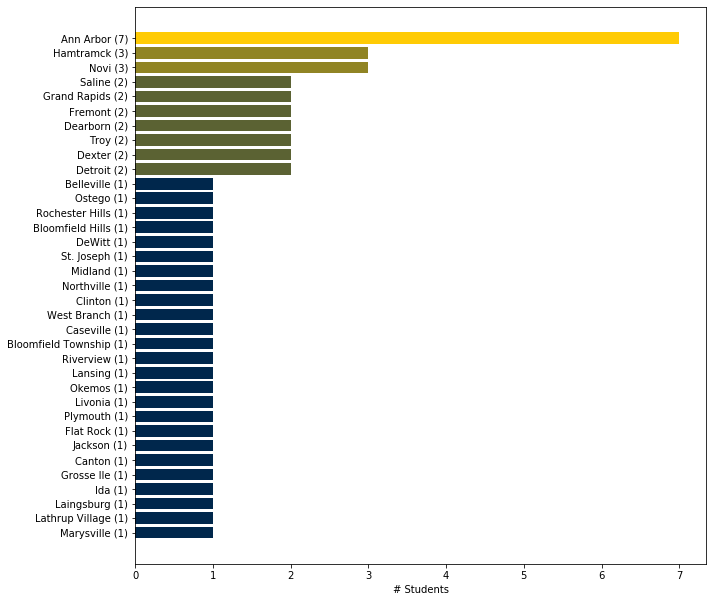

Number of MI cities represented: 35


In [36]:
mi_city_residents_df = city_residents_df[city_residents_df["State"] == "MI"]
num_mi_cities = len(mi_city_residents_df)

data_indices = range(num_mi_cities, 0, -1)
data_values = list(mi_city_residents_df['respondents'])
data_colors = [cm.get_cmap('umich')(log(v)/log(max(data_values))) for v in data_values]
data_y_labels = [f"{s_row[1]['City']} ({s_row[1]['respondents']})" for s_row in mi_city_residents_df.iterrows()]

mi_residents_bar_fig, mi_residents_bar_ax = plt.subplots(figsize=(10.24, 10.24))
mi_residents_bar = mi_residents_bar_ax.barh(data_indices,
                                                  data_values,
                                                  color=data_colors,
                                                  tick_label=data_y_labels,
                                                  log=False)
mi_residents_bar_ax.set_xlabel("# Students")
plt.show()
print(f"Number of MI cities represented: {num_mi_cities}")

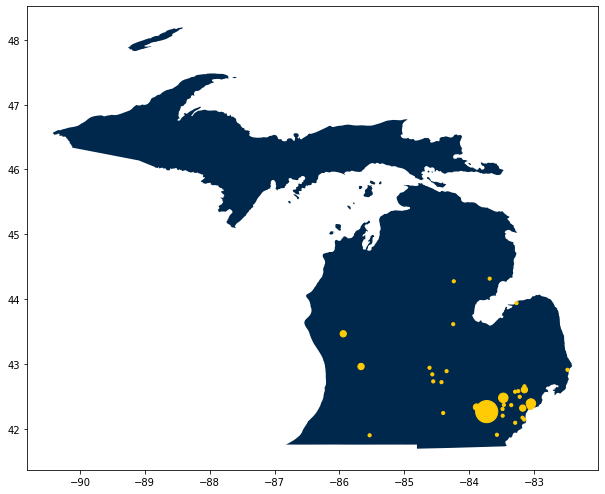

In [51]:
cities_mi_map_fig = plt.figure(figsize=(10.24, 10.24))
cities_mi_ax = cities_mi_map_fig.add_subplot(1,1,1)

us_data[us_data['STUSPS'] == "MI"].plot(ax=cities_mi_ax,
                                        color=BLUE)

mi_city_residents_df.plot(ax=cities_mi_ax,
                          color=MAIZE,
                          markersize='dot_size')
plt.show()

Unsurprisingly, Ann Arbor fields the most representatives, followed by other nearby cities. On the map, the size of the dot indicates how many people live at its location. You can see that most of our Michigan respondents live in south-east Michigan, in or around Ann Arbor and Detroit. Interestingly, we have no one from the Upper Peninsula.

## All Residents

Now we'll zoom all the way back out and look at our students by nationality. First, we need to figure out which countries are represented and how many students come from each. 

In [52]:
# Let's count the number of respondents from each country and make a DataFrame from that
country_resident_nums = defaultdict(int)
for c in student_df['Country']:
    if c == "USA":
        c = "United States"
    country_resident_nums[c] += 1
country_residents_df = pd.DataFrame({'name': list(country_resident_nums.keys()),
                                     'respondents': list(country_resident_nums.values())})
countries_represented = list(country_resident_nums.keys())
    
# Then sort the countries in order of respondents
country_residents_df.sort_values('respondents', inplace=True, ascending=False)
    
# Now print out each non-U.S. country and the number of respondents in order
print("Countries in descending order of respondents:")
for c in country_residents_df.iterrows():
    c_name = c[1]['name']
    c_count = c[1]['respondents']
    print(f"{c_name:<15}: {c_count:<3}")
print("-"*20)
print(f"Total countries represented: {len(country_residents_df)}")

Countries in descending order of respondents:
United States  : 104
China          : 11 
Japan          : 2  
South Korea    : 2  
Mexico         : 2  
Poland         : 1  
Thailand       : 1  
Iran           : 1  
Canada         : 1  
Albania        : 1  
Malaysia       : 1  
Bolivia        : 1  
Qatar          : 1  
Kuwait         : 1  
Philippines    : 1  
India          : 1  
--------------------
Total countries represented: 16


As you can see, the plurality of non-U.S. respondents are from China, with a decent number of other countries in the mix. We will visually represent this data in a histogram, binning non-U.S. and non-China countries into an "Other" category for ease of viewing.

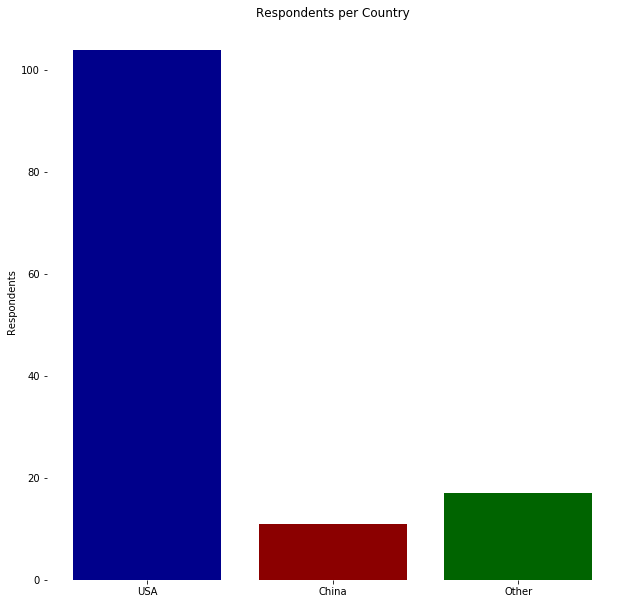

In [53]:
# First, bin all the "Other" countries together and get the U.S. and Chinese counts
other_resident_count = country_residents_df.where(lambda df: df['respondents'] < 10)['respondents'].sum()
us_resident_count = country_residents_df.loc[country_residents_df['name'] == "United States"]['respondents'].sum()
china_resident_count = country_residents_df.loc[country_residents_df['name'] == "China"]['respondents'].sum()

# Now, plot a histogram
country_residents_fig, country_residents_ax = plt.subplots(figsize=(10.24, 10.24))
country_residents_hist = country_residents_ax.bar([0, 1, 2], 
                                                  [us_resident_count, china_resident_count, other_resident_count],
                                                  tick_label = ['USA', 'China', 'Other'],
                                                  color=['darkblue', 'darkred', 'darkgreen'])

country_residents_ax.set_frame_on(False)
country_residents_ax.set_ylabel("Respondents")
country_residents_ax.set_title("Respondents per Country")
plt.show()

Now let's visualize all the respondents, U.S. and non-U.S., on a world map. We'll color every country of origin in a shade of red, with darker shades corresponding to a higher portion of the respondents. 

This is made much easier by the `geopandas` library, which includes a dataset that has geometric data for 176 countries and built-in map plotting.

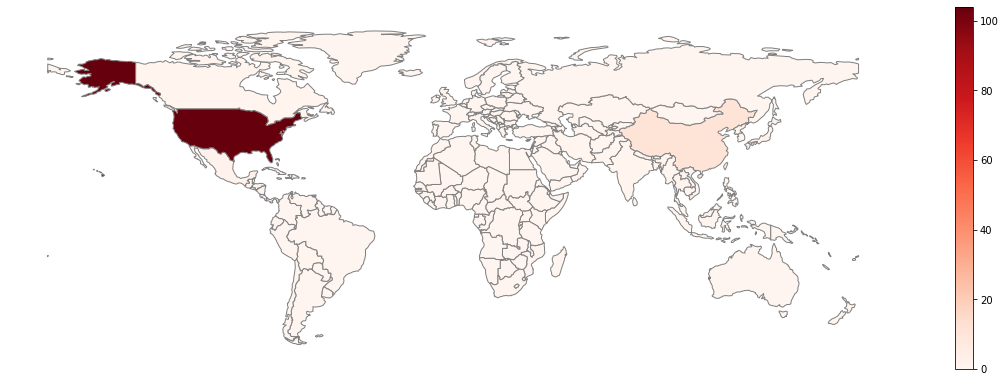

In [54]:
# Load data about the geometry of countries from a low-res dataset that comes with geopandas
world_data = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# Remove Antartica because no one lives there and it's freaking huge
world_data = world_data[(world_data.name != "Antarctica") & (world_data.name != "Fr. S. Antarctic Lands")]

# Insert respondent data into the world_data GeoDataFrame
world_data = pd.merge(world_data, country_residents_df, how='left')
world_data['respondents'] = world_data['respondents'].apply(lambda v: 0 if str(v) == "nan" else int(v))

# Plot the world map
resident_map_lin_fig, resident_map_lin_ax = plt.subplots(figsize=(9.99*2, 3.33*2))
world_data.plot(column='respondents',
                ax=resident_map_lin_ax,
                legend=True,
                cmap='Reds',
                edgecolor='grey')


resident_map_lin_ax.set_frame_on(False)
resident_map_lin_ax.set_axis_off()
plt.show()

So that isn't great, because the U.S. is so dominant it's hard to identify any other country besides china. Let's try again, but using the log base 10 of the number of respondents.

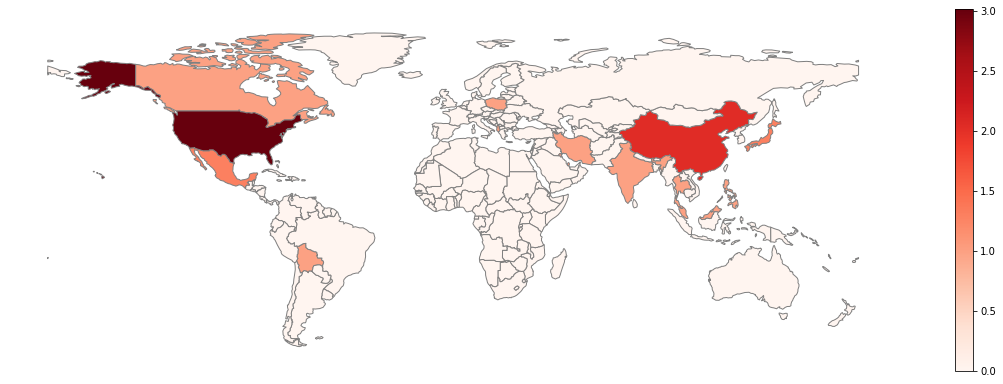

In [55]:
# Calculate log of the number of respondents. We add one to the result for differentiating from 0 respondents
world_data['respondents_log'] = world_data['respondents'].apply(lambda v: 0 if v == 0 else 1 + log(v, 10))

# Plot the world map
resident_map_log_fig, resident_map_log_ax = plt.subplots(figsize=(9.99*2, 3.33*2))
world_data.plot(column='respondents_log',
                ax=resident_map_log_ax,
                legend=True,
                cmap='Reds',
                edgecolor='grey')

resident_map_log_ax.set_frame_on(False)
resident_map_log_ax.set_axis_off()
plt.show()
print()

Neat, that's a bit better! The U.S. is still visually prominent, but other major countries of origin, particularly China, are highlighted as well. 

### Cities of Origin

Now we'll map out which cities in particular everyone comes from. Unlike with U.S. cities, we won't vary dot size based on population, since this would make the map much harder to view. Instead, we'll use the "UMich" color scale, with blue indicating fewer students from the city and maize indicating more.

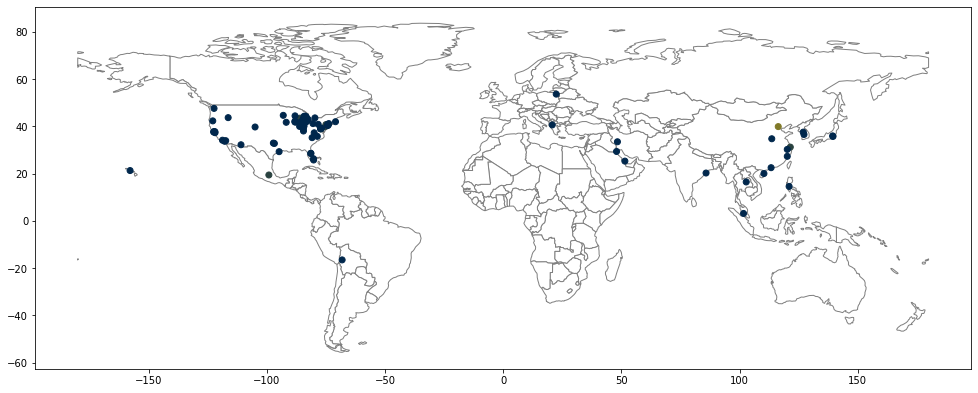

In [65]:
city_resident_map_fig, city_resident_map_ax = plt.subplots(figsize=(9.99*2, 3.33*2))

# Plot the world map first
world_data.plot(ax=city_resident_map_ax,
                edgecolor='grey',
                color='white')

# Now place a dot for each city
city_residents_df.plot(ax=city_resident_map_ax,
                       cmap="umich",
                       column="respondents")

plt.show()

As you can see, we have a very diverse, global set of students! 132 students across 16 countries and four continents make up our How Cities Work Class.

## Travel Distance

Since it's time for winter break, 